# Topics Covered

- Loading and Visualizing the dataset (which contains the exerpts from Shakespeare and their meaning)
- Tokenization using SentencePiece 
- Preprocessing for training the Neural Net. 
- Token embedding 
- Positional encodings

## Dependencies

In [1]:
import numpy as np
import pandas as pd
import sentencepiece as spm
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Dataset

I'll be using [shakespearefy](https://www.kaggle.com/datasets/garnavaurha/shakespearify) dataset for training.

I'm not splitting it into training and testing subsets because
- It's a really small dataset of size ~50k and,
- My goal is to just understand how an autoregressive transformer works.

### Loading...

There are a total of around 50k shakespeare sentences and the accompanying translation.

In [2]:
df = pd.read_csv("../data/shk2mod.csv", index_col=0)                            # Loading the csv file
df.drop("id", axis=1, inplace=True)                                             # Dropping the index column                                 
df.rename(columns={"og": "shakespeare eng", "t": "modern eng"}, inplace=True)   # Renaming columns
df

,shakespeare eng,modern eng
0,You do not meet a man but frowns:,Every man you meet these days is frowning.
1,our bloods No more obey the heavens than our...,Our bodies are in agreement with the planetar...
2,But what's the matter?,What's wrong?
3,"His daughter, and the heir of's kingdom, whom...","The king wanted his daughter, the only heir to..."
4,she's wedded; Her husband banish'd; she impr...,"She's married, her husband is banished, she's..."
...,...,...
205,He hath not told us of the captain yet.,He hasn't told us about that captain yet.
206,"When that is known and golden time convents, ...",When that's taken care of and the time is conv...
207,"Meantime, sweet sister, We will not part fro...","Until then, sweet sister-in-law, we won't leav..."
208,"Cesario, come, For so you shall be, while yo...","Cesario, come here. You'll be Cesario to me wh..."


For converting shakespeare to modern english, the source will be shakespeare sentence and the target will be modern english sentence.

In [3]:
d = df.to_numpy()           # Converting dataframe to numpy
src, trg = d[:,0], d[:,1]   # Splitting columns into source and target
print("SRC shape: {}; TRG shape: {}".format(src.shape, trg.shape))

SRC shape: (51787,); TRG shape: (51787,)


## Tokenizer

For this work I decided to go with [SentencePiece](https://github.com/google/sentencepiece) tokenizer. It is a data driven tokenizer where by setting the vocabulary size, we can control the level of subword tokenization.

Let's start with the modern english sentences and set a really small vocabulary size of 100.

In [ ]:
# Training Tokenizer of the dataset
spm.SentencePieceTrainer.Train(sentence_iterator=iter(trg),                                 # Load dataset
                               pad_id=0, bos_id=1, eos_id=2, unk_id=3,                      # Reserve preprocessing tokens
                               model_prefix="../trained_models/tokenizer/modern_en_vs100",  # Where to save the model
                               vocab_size=100)   

This creates two files named *modern_en.model* and *modern_en.vocab* in *trained_models/tokenizer* directory. You can open *.vocab* file and it is a list of each word in the vocabulary. Looking at the *.vocab* file, you might have noticed that it's almost a character level tokenizer.

We can observe the same thing when we use *.model* file to tokenize the dataset.

In [4]:
modern = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/modern_en_vs100.model") # Loading the tokenizer model
print("Original Sentence: ", trg[0])
print("Tokenized Sentence: ", modern.EncodeAsPieces(trg[0]))

Original Sentence:  Every man you meet these days is frowning.
Tokenized Sentence:  ['▁', 'E', 've', 'r', 'y', '▁ma', 'n', '▁you', '▁me', 'e', 't', '▁the', 's', 'e', '▁', 'd', 'a', 'y', 's', '▁', 'i', 's', '▁', 'f', 'r', 'ow', 'n', 'ing', '.']


So what I really want is a vocabulary size such that words are kept intact but the common suffixes like 's', 'tion', 'ing', etc are separated. 

Let me show you what I mean here.

In [ ]:
# Training tokenizer with a better vocab size
spm.SentencePieceTrainer.Train(sentence_iterator=iter(trg),                                 # Load dataset
                               pad_id=0, bos_id=1, eos_id=2, unk_id=3,                      # Reserve preprocessing tokens
                               model_prefix="../trained_models/tokenizer/modern_en",           # Where to save the model
                               vocab_size=5000)  

In [5]:
# Let's see the tokenization now
modern = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/modern_en.model") # Loading the tokenizer model
print("Original Sentence: ", trg[0])
print("Tokenized Sentence: ", modern.EncodeAsPieces(trg[0]))

Original Sentence:  Every man you meet these days is frowning.
Tokenized Sentence:  ['▁Every', '▁man', '▁you', '▁meet', '▁these', '▁days', '▁is', '▁frown', 'ing', '.']


Let's now do the same thing for shakespeare sentences as well.

> We can pick a different vocab size here but I'll keep it simple and use the same vocab size as before.

In [ ]:
# Training shakespeare tokenizer
spm.SentencePieceTrainer.Train(sentence_iterator=iter(src),                                 # Load dataset
                               pad_id=0, bos_id=1, eos_id=2, unk_id=3,                      # Reserve preprocessing tokens
                               model_prefix="../trained_models/tokenizer/shakespeare_en",   # Where to save the model
                               vocab_size=5000)  

In [8]:
# Shakespeare tokenization
shakespeare = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/shakespeare_en.model") # Loading the tokenizer model
print("Original Sentence: ", src[0])
print("Tokenized Sentence: ", shakespeare.EncodeAsPieces(src[0]))

Original Sentence:   You do not meet a man but frowns: 
Tokenized Sentence:  ['▁You', '▁do', '▁not', '▁meet', '▁a', '▁man', '▁but', '▁frown', 's', ':']


A computer only understands numbers. We can easily convert these tokens into unique integers with a single line of code.

In [7]:
# Encoding src
shakespeare = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/shakespeare_en.model")
src_id = shakespeare.EncodeAsIds(list(src))

# Encoding trg
modern = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/modern_en.model")
trg_id = modern.EncodeAsIds(list(trg))

print("Original Shakespeare Sentence: ", src[0])
print("Tokenized Shakespeare Sentence: ", shakespeare.EncodeAsPieces(src[0]))
print("Numericalized Shakespeare Sentence: ", src_id[0])
print("\n")
print("Original modern english Sentence: ", trg[0])
print("Tokenized modern english Sentence: ", modern.EncodeAsPieces(trg[0]))
print("Numericalized modern english Sentence: ", trg_id[0])

Original Shakespeare Sentence:   You do not meet a man but frowns: 
Tokenized Shakespeare Sentence:  ['▁You', '▁do', '▁not', '▁meet', '▁a', '▁man', '▁but', '▁frown', 's', ':']
Numericalized Shakespeare Sentence:  [107, 48, 23, 427, 12, 87, 50, 1530, 6, 26]


Original modern english Sentence:  Every man you meet these days is frowning.
Tokenized modern english Sentence:  ['▁Every', '▁man', '▁you', '▁meet', '▁these', '▁days', '▁is', '▁frown', 'ing', '.']
Numericalized modern english Sentence:  [1953, 66, 10, 506, 161, 842, 20, 1534, 38, 5]


## Preprocessing

If you look at the complete dataset, you'll see that different sentences contains different number of tokens. To load multiple sentences at once and utilize parallelization, we'll have to pad them with zeros to make them of equal lengths. I decided the maximum sequence length by looking at the Cumulative Density Function of the lengths of different numericalized sequences.

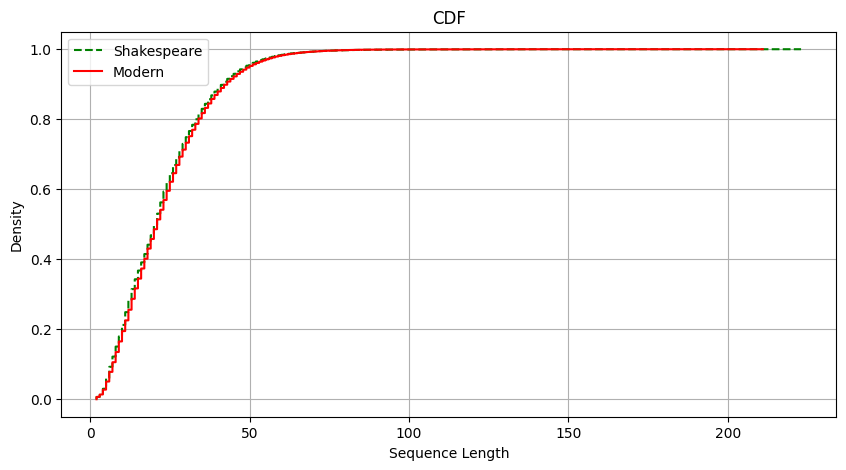

In [8]:
plt.rcParams["figure.figsize"] = (10,5)
# Let's see what length distribution of sentences in both src and trg
src_len = []
trg_len = []

for (src_snt, trg_snt) in zip(src_id, trg_id):
    src_len.append(len(src_snt)) # Store len of an individual src
    trg_len.append(len(trg_snt)) # Store len of an individual trg

plt.plot(np.sort(src_len), np.arange(len(src_len))/len(src_len), label="Shakespeare", linestyle="--", color="green")
plt.plot(np.sort(trg_len), np.arange(len(trg_len))/len(trg_len), label="Modern", color="red")
plt.grid()
plt.xlabel("Sequence Length")
plt.ylabel("Density")
plt.legend()
plt.title("CDF")
plt.savefig("./figs/cdf.png")
plt.show()

From the CDF we can see that most of the sentences are under 100 tokens long and the maximum sequence length is just over 200. So to cover all the possible sequence sizes, I'll go with the max sequence length of 256.

In [11]:
# Max Sequence Length
max_seq_len = 256

Next step is to add these padding tokens alongside the "Beginning of Sentence [BOS]" and "End of Sentence [EOS]" tokens. Here are the relevant details:
- [EOS] token for the input to the encoder (just before the padding starts).
- [BOS] token for the input to the decoder (at the very start of the sentence).
- [EOS] token for the output to the decoder (just before the padding starts).

Remember while training the tokenizer I reserved:
- 0 for padding
- 1 for BOS
- 2 for EOS

In [9]:
# Input to the encoder
def src_processing(tokenized_text, max_seq_len):
    # Padding or trimming to fit the max sequence length
    if len(tokenized_text) < max_seq_len:
        # Add EOS token at the end
        tokenized_text += [2]
        left = max_seq_len - len(tokenized_text)
        padding = [0] * left
        tokenized_text += padding
    else:
        tokenized_text = tokenized_text[:max_seq_len-1]
        # Add EOS token at the end
        tokenized_text += [2]

    return tokenized_text

# Input to Decoder
def input_trg_processing(tokenized_text, max_seq_len):
    # Add BOS token at the start
    tokenized_text = [1] + tokenized_text
    # Padding or trimming to fit the max sequence length
    if len(tokenized_text) < max_seq_len:
        left = max_seq_len - len(tokenized_text)
        padding = [0] * left
        tokenized_text += padding
    else:
        tokenized_text = tokenized_text[:max_seq_len]
    return tokenized_text

# Output for Decoder
def output_trg_processing(tokenized_text, max_seq_len):
    # Padding or trimming to fit the max sequence length
    if len(tokenized_text) < max_seq_len:
        # Add EOS token at the end
        tokenized_text += [2]
        left = max_seq_len - len(tokenized_text)
        padding = [0] * left
        tokenized_text += padding
    else:
        tokenized_text = tokenized_text[:max_seq_len-1]
        # Add EOS token at the end
        tokenized_text += [2]
    return tokenized_text

In [12]:
# Padding/Truncating src
src_id = [src_processing(id, max_seq_len) for id in src_id] 

# Padding/Truncating trg
input_trg_id = [input_trg_processing(id, max_seq_len) for id in trg_id] 
output_trg_id = [output_trg_processing(id, max_seq_len) for id in trg_id] 

In [13]:
# Moving everything to torch tensors
src_id = torch.tensor(src_id)
input_trg_id = torch.tensor(input_trg_id)
output_trg_id = torch.tensor(output_trg_id)

print("Src Shapes: {}; dtype: {}".format(src_id.shape, src_id.dtype))
print("Input Trg Shapes: {}; dtype: {}".format(input_trg_id.shape, input_trg_id.dtype))
print("Output Trg Shapes: {}; dtype: {}".format(output_trg_id.shape, output_trg_id.dtype))

Src Shapes: torch.Size([51787, 256]); dtype: torch.int64
Input Trg Shapes: torch.Size([51787, 256]); dtype: torch.int64
Output Trg Shapes: torch.Size([51787, 256]); dtype: torch.int64


# Token Embeddings

Right now we are at a stage where the sentences are represented as a sequence of integers and there is some sense of semantics in these integers but wouldn't it be better to represent the tokens as vectors rather than simple integers? How about the vectors that learn alongside the neural net and adjust themselves based on the dataset.

To do this I will be using the `Embedding` layer from PyTorch. You can think of it like a linear layer whose input dimension is equal to the number of tokens in the vocabulary and the output is the desired embedding vector. We can adjust the length of this output and the higher the dimension of this vector, the more information it can encode.

In [14]:
# Token Embeddings mapping each token in the src/trg vocab to a vector of length emb
src_token_emb = torch.nn.Embedding(num_embeddings=shakespeare.vocab_size(), embedding_dim=16)
trg_token_emb = torch.nn.Embedding(num_embeddings=modern.vocab_size(), embedding_dim=16)

-------------------Shakespeare Dataset-------------------------
Original Sentence:   You do not meet a man but frowns: 
Tokenized Sentence (1st 12 tokens):  ['You', 'do', 'not', 'meet', 'a', 'man', 'but', 'frown', 's', ':', '[EOS]', '[PAD]']
Numericalized Sentence (1st 12 tokens):  tensor([ 107,   48,   23,  427,   12,   87,   50, 1530,    6,   26,    2,    0])
Token Embedded Sentence (1st 12 tokens): 


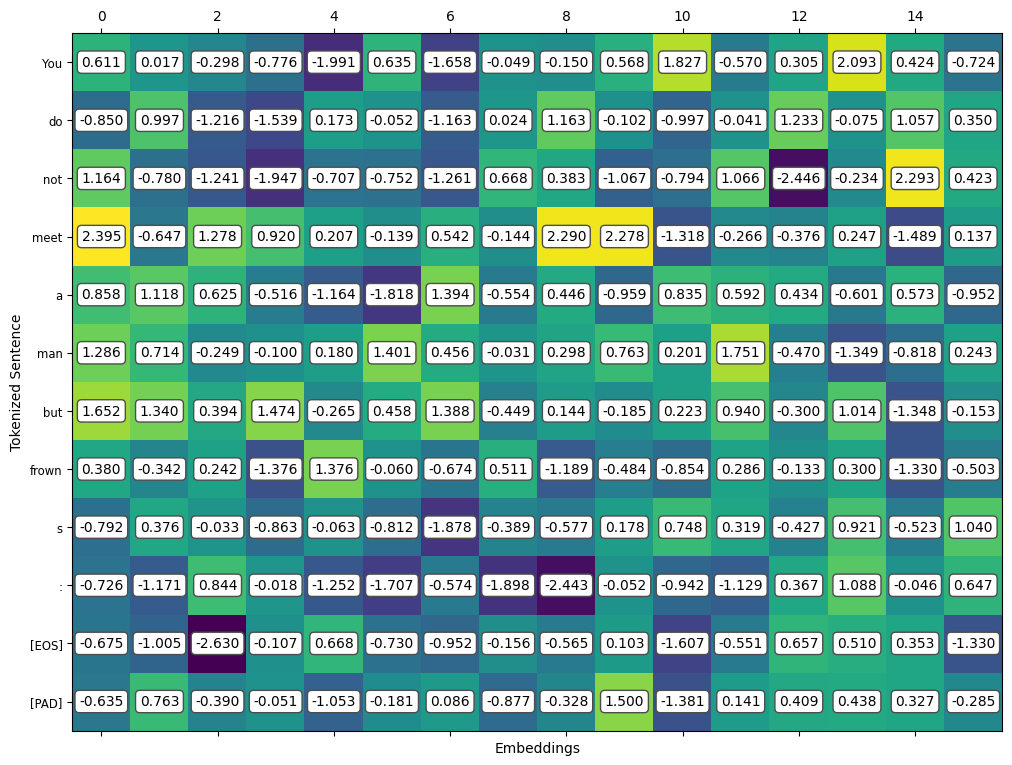

-----------------Modern English Dataset-------------------------
Original Sentence:  Every man you meet these days is frowning.
Tokenized Sentence (1st 12 tokens):  ['Every', 'man', 'you', 'meet', 'these', 'days', 'is', 'frown', 'ing', '.', '[EOS]', '[PAD]']
Numericalized Sentence (1st 12 tokens):  tensor([   1, 1953,   66,   10,  506,  161,  842,   20, 1534,   38,    5,    0])
Token Embedded Sentence (1st 12 tokens): 


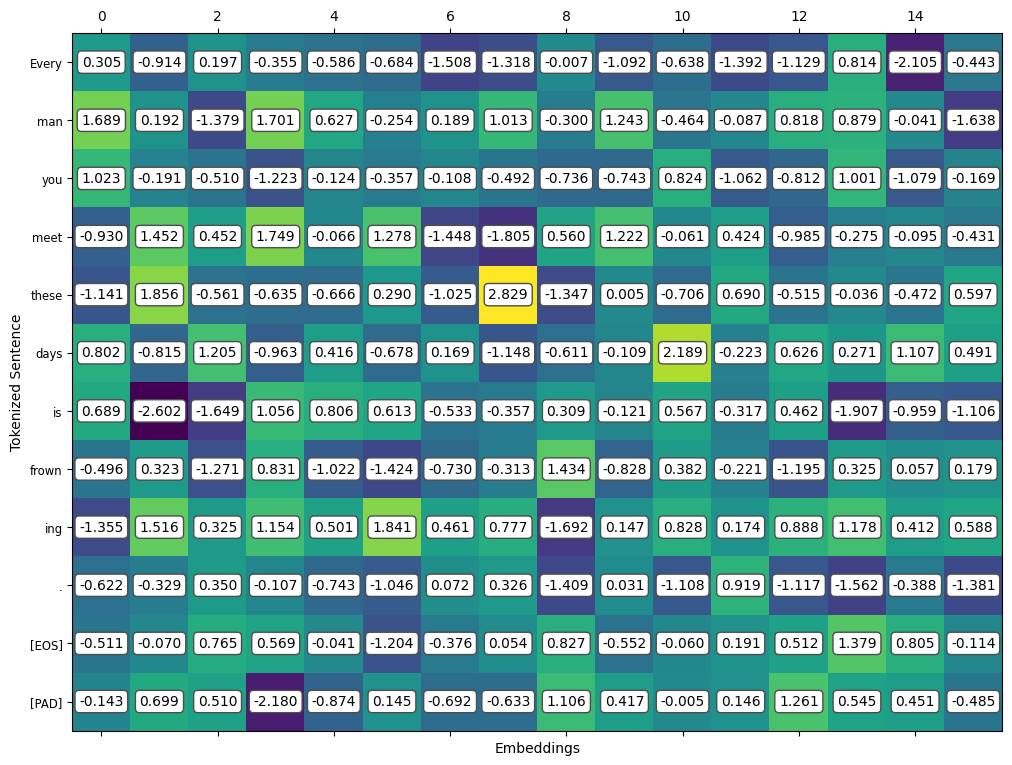

In [36]:
plt.rcParams["figure.figsize"] = (12,10)

# Example Sentence
print("-------------------Shakespeare Dataset-------------------------")
print("Original Sentence: ", src[0])
tokens = shakespeare.EncodeAsPieces(src[0])
tokens += ["[EOS]"] # EOS Token string
tokens = (tokens + max_seq_len * ['[PAD]'])[:max_seq_len] # Padding Tokens string
tokens = [piece.lstrip('▁') for piece in tokens]
print("Tokenized Sentence (1st 12 tokens): ", tokens[:12])

print("Numericalized Sentence (1st 12 tokens): ", src_id[0][:12])

print("Token Embedded Sentence (1st 12 tokens): ")
fig, ax = plt.subplots()
data = src_token_emb(src_id)[0].detach().numpy()[:12]
im = ax.matshow(data)
# Create text objects to display the values
text_objects = []
for (i, j), z in np.ndenumerate(data):
    text = ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(len(tokens[:12])), tokens[:12], size='small')
ax.set_ylabel("Tokenized Sentence")
ax.set_xlabel("Embeddings")
plt.show()

print("-----------------Modern English Dataset-------------------------")
print("Original Sentence: ", trg[0])
tokens = modern.EncodeAsPieces(trg[0])
tokens += ["[EOS]"] # EOS Token string
tokens = (tokens + max_seq_len * ['[PAD]'])[:max_seq_len] # Padding Tokens string
tokens = [piece.lstrip('▁') for piece in tokens]

print("Tokenized Sentence (1st 12 tokens): ", tokens[:12])

print("Numericalized Sentence (1st 12 tokens): ", input_trg_id[0][:12])

print("Token Embedded Sentence (1st 12 tokens): ")
fig, ax = plt.subplots()
data = trg_token_emb(input_trg_id)[0].detach().numpy()[:12]
im = ax.matshow(data)
# Create text objects to display the values
text_objects = []
for (i, j), z in np.ndenumerate(data):
    text = ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(len(tokens[:12])), tokens[:12], size='small')
ax.set_ylabel("Tokenized Sentence")
ax.set_xlabel("Embeddings")
plt.show()

As these embedding layers are essentially learnable, it makes sense to wrap this into the Transformer itself.

```py
class Transformer(torch.nn.Module):
    def __init__(self, emb, _, _, src_vocab_len, trg_vocab_len, _, device="cpu):
        super().__init__()
        # Device and layers
        self.device = device
        
        # Token Embeddings
        self.src_token_emb = torch.nn.Embedding(src_vocab_len, emb)
        self.trg_token_emb = torch.nn.Embedding(trg_vocab_len, emb)

        # Positional Embeddings

        # Encoder

        # Decoder 

        # Generator

    def forward(self, src_in, trg_in, e_mask=None, d_mask=None):
        # SRC Tokenized and pos embedded
        src_in = self.src_token_emb(src_in) 
        
        # TRG Tokenized and pos embedded
        trg_in = self.trg_token_emb(trg_in) 
        
        # Encoder
        
        # Decoder
        
        # Generator
        

        return 
```

# Positional Encoding

After Token embedding, each token in the sequence is represented as a vector. A problem here is that there is no sense of position in this matrix. Let me explain what I mean here. Consider the two sentences
- The boy hit the ball.
- The ball hit the boy.

Semantically, these two sentences couldn't be any more different. But, if I look at the token embedding vectors for the word boy in the two senteces, they're exactly same. Moreover, a Transformer is designed to processes the complete sentence at once, making it crucial to add the positional information to each token.

In [53]:
# Example Sentence
stn1 = ["The boy thanked the king"]
stn2 = ["The king thanked the boy"]

# 1st Sentence
print("-------------------First Sentence-------------------------")
print("Original Sentence: ", stn1[0])
stn1_id = modern.EncodeAsIds(list(stn1))
tokens = shakespeare.EncodeAsPieces(stn1[0])
tokens += ["[EOS]"] # EOS Token string
tokens = (tokens + max_seq_len * ['[PAD]'])[:max_seq_len] # Padding Tokens string
tokens = [piece.lstrip('▁') for piece in tokens]
stn1_id = [src_processing(id, 256) for id in stn1_id] 
stn1_emb = src_token_emb(torch.tensor(stn1_id))[0]
print("Tokenized Sentence (1st 8 tokens): ", tokens[:8])

print("Numericalized Sentence (1st 8 tokens): ", stn1_id[0][:8])

print("Embedding Vector for word boy: ", np.round(stn1_emb[1].detach().numpy(), 3))

# 2nd Sentence
print("-------------------Second Sentence-------------------------")
print("Original Sentence: ", stn2[0])
stn2_id = modern.EncodeAsIds(list(stn2))
tokens = shakespeare.EncodeAsPieces(stn2[0])
tokens += ["[EOS]"] # EOS Token string
tokens = (tokens + max_seq_len * ['[PAD]'])[:max_seq_len] # Padding Tokens string
tokens = [piece.lstrip('▁') for piece in tokens]
stn2_id = [src_processing(id, 256) for id in stn2_id] 
stn2_emb = src_token_emb(torch.tensor(stn2_id))[0]
print("Tokenized Sentence (1st 8 tokens): ", tokens[:8])

print("Numericalized Sentence (1st 8 tokens): ", stn2_id[0][:8])

print("Embedding Vector for word boy: ", np.round(stn2_emb[5].detach().numpy(), 3))

-------------------First Sentence-------------------------
Original Sentence:  The boy thanked the king
Tokenized Sentence (1st 8 tokens):  ['The', 'boy', 'thank', 'ed', 'the', 'king', '[EOS]', '[PAD]']
Numericalized Sentence (1st 8 tokens):  [83, 360, 496, 39, 9, 118, 2, 0]
Embedding Vector for word boy:  [-0.365  0.327 -1.035 -0.374  0.062 -0.968 -0.479 -0.99   1.474 -1.356
 -1.47  -0.98  -0.951  0.54   1.272 -1.867]
-------------------Second Sentence-------------------------
Original Sentence:  The king thanked the boy
Tokenized Sentence (1st 8 tokens):  ['The', 'king', 'thank', 'ed', 'the', 'boy', '[EOS]', '[PAD]']
Numericalized Sentence (1st 8 tokens):  [83, 118, 496, 39, 9, 360, 2, 0]
Embedding Vector for word boy:  [-0.365  0.327 -1.035 -0.374  0.062 -0.968 -0.479 -0.99   1.474 -1.356
 -1.47  -0.98  -0.951  0.54   1.272 -1.867]


In the original "Attention is all you need" paper, to add positional information to the embeddings, they used static vectors, but I'm again going to use the `Embedding` layer. The difference here (compared to the token embedding layer) is that I'm now mapping each position in the sequence to a vector of length equal to the embedding dimension.

In simple words, as I have the max sequence length of 256, the positional embedding layer creates a unique vector for each of the 256 positions in the sequence. 

In [59]:
# Positional Encoding
src_pos_enc = torch.nn.Embedding(embedding_dim=16, num_embeddings=max_seq_len)
trg_pos_enc = torch.nn.Embedding(embedding_dim=16, num_embeddings=max_seq_len)

Now when these positional encodings are added to the embedding vectors, we can see that the resulting vector represetnation of a word will depend on it's position in the sentence as well.

In [61]:
# Example Sentence
stn1 = ["The boy thanked the king"]
stn2 = ["The king thanked the boy"]

# 1st Sentence
print("-------------------First Sentence-------------------------")
print("Original Sentence: ", stn1[0])
stn1_id = modern.EncodeAsIds(list(stn1))
tokens = shakespeare.EncodeAsPieces(stn1[0])
tokens += ["[EOS]"] # EOS Token string
tokens = (tokens + max_seq_len * ['[PAD]'])[:max_seq_len] # Padding Tokens string
tokens = [piece.lstrip('▁') for piece in tokens]
stn1_id = [src_processing(id, 256) for id in stn1_id] 
stn1_emb_pos_enc = src_token_emb(torch.tensor(stn1_id))[0] + src_pos_enc(torch.arange(max_seq_len, device="cpu"))
print("Tokenized Sentence (1st 8 tokens): ", tokens[:8])

print("Numericalized Sentence (1st 8 tokens): ", stn1_id[0][:8])

print("Embedding Vector with positional encoding for word boy: ", np.round(stn1_emb_pos_enc[1].detach().numpy(), 3))

# 2nd Sentence
print("-------------------Second Sentence-------------------------")
print("Original Sentence: ", stn2[0])
stn2_id = modern.EncodeAsIds(list(stn2))
tokens = shakespeare.EncodeAsPieces(stn2[0])
tokens += ["[EOS]"] # EOS Token string
tokens = (tokens + max_seq_len * ['[PAD]'])[:max_seq_len] # Padding Tokens string
tokens = [piece.lstrip('▁') for piece in tokens]
stn2_id = [src_processing(id, 256) for id in stn2_id] 
stn2_emb_pos_enc = src_token_emb(torch.tensor(stn2_id))[0] + src_pos_enc(torch.arange(max_seq_len, device="cpu"))
print("Tokenized Sentence (1st 8 tokens): ", tokens[:8])

print("Numericalized Sentence (1st 8 tokens): ", stn2_id[0][:8])

print("Embedding Vector with positional encoding for word boy: ", np.round(stn2_emb_pos_enc[5].detach().numpy(), 3))

-------------------First Sentence-------------------------
Original Sentence:  The boy thanked the king
Tokenized Sentence (1st 8 tokens):  ['The', 'boy', 'thank', 'ed', 'the', 'king', '[EOS]', '[PAD]']
Numericalized Sentence (1st 8 tokens):  [83, 360, 496, 39, 9, 118, 2, 0]
Embedding Vector with positional encoding for word boy:  [-0.261 -0.341 -1.129  1.815  0.275 -1.107 -0.948 -0.136  1.773 -2.
 -1.442 -0.458 -0.83   1.429 -0.223 -4.107]
-------------------Second Sentence-------------------------
Original Sentence:  The king thanked the boy
Tokenized Sentence (1st 8 tokens):  ['The', 'king', 'thank', 'ed', 'the', 'boy', '[EOS]', '[PAD]']
Numericalized Sentence (1st 8 tokens):  [83, 118, 496, 39, 9, 360, 2, 0]
Embedding Vector with positional encoding for word boy:  [ 0.597  0.979 -1.448 -2.104 -0.079 -1.969 -1.376 -0.228  1.174 -1.011
 -4.062 -1.    -1.693 -1.97   0.462 -1.298]


Note that when I'm actually using the position embedding layer, the input is a sequence of integers. What this means is that, the position encoding vectors do not depend on the tokens itself. Instead they only care about the position of the token in a sequence.

In context of our shakespeare dataset, this positional information is then added to the token embedding vectors for both source and target. These are then learned together alongside the neural network.

Similar to the token embedding, these layers (one for the source and one for the target) are rolled into the Transformer definition itself.

```py
class Transformer(torch.nn.Module):
    def __init__(self, emb, _, max_seq_len, src_vocab_len, trg_vocab_len, _, device="cpu"):
        super().__init__()
        # Device and layers
        self.device = device
        
        # Token Embeddings
        self.src_token_emb = torch.nn.Embedding(src_vocab_len, emb)
        self.trg_token_emb = torch.nn.Embedding(trg_vocab_len, emb)

        # Positional Embeddings
        self.src_pos_enc = torch.nn.Embedding(embedding_dim=emb, num_embeddings=max_seq_len)
        self.trg_pos_enc = torch.nn.Embedding(embedding_dim=emb, num_embeddings=max_seq_len)

        # Encoder

        # Decoder 

        # Generator

    def forward(self, src_in, trg_in, e_mask=None, d_mask=None):
        # SRC Tokenized
        src_in = self.src_token_emb(src_in) 
        # pos embedded
        b, t, emb = src_in.shape
        src_in = src_in + self.src_pos_enc(torch.arange(t, device=self.device))[None, :, :].expand(b, t, emb)
        
        # TRG Tokenized
        trg_in = self.trg_token_emb(trg_in) 
        # pos embedded
        b, t, emb = trg_in.shape
        trg_in = trg_in + self.trg_pos_enc(torch.arange(t, device=self.device))[None, :, :].expand(b, t, emb)
        
        # Encoder
        
        # Decoder
        
        # Generator
        

        return 
```